# TP n°8 : Banc MCC-MS

**Traitement des données et génération des figures**

Ce notebook génère les 4 figures du compte-rendu et affiche les résultats numériques (avec incertitudes et unités).

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

# Configuration
ROUGE = '#B22133'
plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['font.family'] = 'serif'

os.makedirs('figures', exist_ok=True)
print("Configuration chargée.")

Configuration chargée.


## 1. Fonctions utilitaires

### Calcul des incertitudes (données constructeur)

In [74]:
# Constante tachymètre
K_TACHY = 0.06  # V/(tr/min)
DELTA_K_REL = 0.01  # 1% incertitude relative sur K_TACHY

# Résolutions
RES_V = 0.1  # V
RES_W_WATTMETRE = 1.0  # W
RES_W_PINCE = 1.0  # W

def incertitude_tension(U):
    """Wattmètre mode voltmètre: ±(1%L + 2 digits), résolution 0.1 V.
    Retourne une incertitude-type (même convention que le CR) en V.
    """
    U = np.asarray(U, dtype=float)
    return np.sqrt((0.01 * np.abs(U))**2 + (2 * RES_V)**2)

def incertitude_puissance_pince(P):
    """Pince F205 puissance DC: ±(2%L + 10 digits), résolution 1 W.
    Retourne une incertitude-type en W.
    """
    P = np.asarray(P, dtype=float)
    return np.sqrt((0.02 * np.abs(P))**2 + (10 * RES_W_PINCE)**2)

def incertitude_puissance_wattmetre(P):
    """Wattmètre 10W-1kW: ±(1%L + 2 digits), résolution 1 W.
    Retourne une incertitude-type en W.
    """
    P = np.asarray(P, dtype=float)
    return np.sqrt((0.01 * np.abs(P))**2 + (2 * RES_W_WATTMETRE)**2)

def convert_to_omega_rad(U_tachy):
    """U_tachy (V) -> vitesse angulaire Ω (rad/s)."""
    U_tachy = np.asarray(U_tachy, dtype=float)
    omega_rpm = U_tachy / K_TACHY
    return omega_rpm * 2 * np.pi / 60

def incertitude_omega(U_tachy):
    """Propagation des incertitudes sur Ω.
    Combine incertitude sur U_tachy (wattmètre) et sur K_TACHY (1%).
    Retourne ΔΩ en rad/s.
    """
    U_tachy = np.asarray(U_tachy, dtype=float)
    delta_U = incertitude_tension(U_tachy)
    omega = convert_to_omega_rad(U_tachy)
    delta_omega_rel = np.sqrt((delta_U / U_tachy)**2 + DELTA_K_REL**2)
    return omega * delta_omega_rel

def linregress_with_uncertainties(x, y):
    """Régression linéaire y = a x + b avec estimation des incertitudes sur a et b.
    Utilise scipy.stats.linregress.
    Retourne a, ua, b, ub.
    """
    res = stats.linregress(x, y)
    a = float(res.slope)
    b = float(res.intercept)
    ua = float(res.stderr) if getattr(res, 'stderr', None) is not None else float('nan')
    # intercept_stderr est présent dans les versions récentes de SciPy
    if hasattr(res, 'intercept_stderr') and res.intercept_stderr is not None:
        ub = float(res.intercept_stderr)
    else:
        # Fallback rigoureux: ub = s * sqrt(1/n + xbar^2 / Sxx)
        x = np.asarray(x, dtype=float)
        y = np.asarray(y, dtype=float)
        n = len(x)
        xbar = np.mean(x)
        Sxx = np.sum((x - xbar)**2)
        residuals = y - (a * x + b)
        if n > 2 and Sxx > 0:
            s = np.sqrt(np.sum(residuals**2) / (n - 2))
            ub = float(s * np.sqrt(1/n + (xbar**2)/Sxx))
        else:
            ub = float('nan')
    return a, ua, b, ub

print("Fonctions d'incertitude définies.")

Fonctions d'incertitude définies.


## 2. Données expérimentales - FEM induite E(Ω)

In [75]:
# Format: {I_inducteur (A): [(E (V), U_tachy (V)), ...]}
data_fem = {
    1.91: [(4.6, 29.3), (5.6, 35.8), (6.1, 39.3), (6.8, 43.9), (7.9, 51.2), (9.5, 62.2)],
    3.68: [(2.1, 12.8), (5.6, 34.3), (6.4, 39.6), (7.4, 45.8), (8.3, 52.3), (9.0, 56.4)],
    5.24: [(3.1, 17.9), (6.4, 37.7), (7.2, 42.7), (8.2, 49.1), (9.3, 56.1), (10.4, 62.8)],
    7.60: [(6.0, 33.7), (6.8, 37.9), (8.3, 47.0), (9.5, 54.4), (10.8, 61.4), (12.2, 70.4)],
    9.53: [(5.5, 29.0), (7.2, 38.7), (8.6, 46.2), (10.6, 57.5), (12.3, 66.9), (13.2, 72.8)]
}

print(f"Données chargées : {len(data_fem)} valeurs de i_inducteur (A)")
for I, mesures in data_fem.items():
    print(f"  i = {I:.2f} A : {len(mesures)} points")

Données chargées : 5 valeurs de i_inducteur (A)
  i = 1.91 A : 6 points
  i = 3.68 A : 6 points
  i = 5.24 A : 6 points
  i = 7.60 A : 6 points
  i = 9.53 A : 6 points


## 3. Figure 1 : E(Ω) pour différents i_inducteur

**Méthode de régression :** moindres carrés ordinaires (`scipy.stats.linregress`).  
On minimise $\sum_i (E_i - a\Omega_i - b)^2$ pour trouver la pente $a$ (en V·s/rad) et l'ordonnée $b$ (en V).

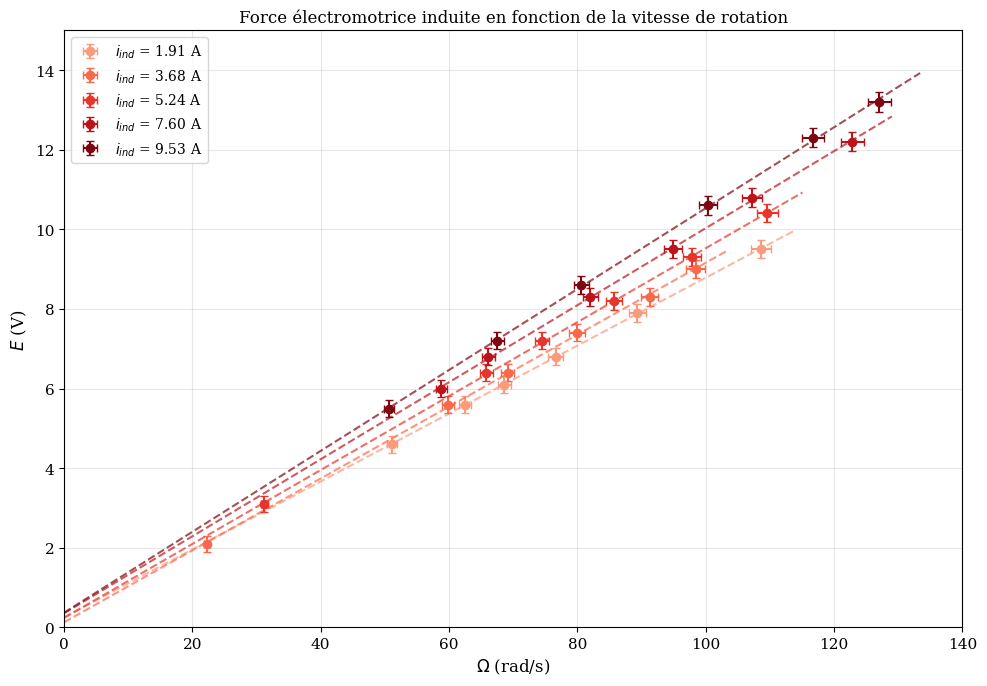

In [76]:
fig1, ax1 = plt.subplots(figsize=(10, 7))
colors = plt.cm.Reds(np.linspace(0.35, 0.95, 5))
markers = ['o'] * len(colors)
results_regression = {}

for idx, (I_ind, measurements) in enumerate(data_fem.items()):
    E_vals = np.array([m[0] for m in measurements], dtype=float)
    U_tachy_vals = np.array([m[1] for m in measurements], dtype=float)
    
    omega_vals = convert_to_omega_rad(U_tachy_vals)
    delta_omega = incertitude_omega(U_tachy_vals)
    delta_E = incertitude_tension(E_vals)
    
    # Régression linéaire E = a*Omega + b
    a, ua, b, ub = linregress_with_uncertainties(omega_vals, E_vals)
    
    results_regression[I_ind] = {
        'slope': a,
        'slope_stderr': ua,
        'intercept': b,
        'intercept_stderr': ub
    }
    
    # Tracé (barres d'erreur instrumentales)
    ax1.errorbar(omega_vals, E_vals, xerr=delta_omega, yerr=delta_E,
                 fmt=markers[idx], color=colors[idx], capsize=3, markersize=6,
                 label=f'$i_{{ind}}$ = {I_ind:.2f} A')
    
    omega_fit = np.linspace(0, max(omega_vals)*1.05, 100)
    E_fit = a * omega_fit + b
    ax1.plot(omega_fit, E_fit, '--', color=colors[idx], alpha=0.7, linewidth=1.5)

ax1.set_xlabel(r'$\Omega$ (rad/s)', fontsize=12)
ax1.set_ylabel(r'$E$ (V)', fontsize=12)
ax1.set_title('Force électromotrice induite en fonction de la vitesse de rotation', fontsize=12)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 140)
ax1.set_ylim(0, 15)
plt.tight_layout()
plt.savefig('figures/figure1_E_omega.png', dpi=300, bbox_inches='tight')
plt.show()

In [77]:
# Tableau des résultats (avec unités)
print("RÉSULTATS DES RÉGRESSIONS LINÉAIRES : E = a·Ω + b")
print("="*86)
print(f"{'i_ind (A)':<12} {'a (V·s/rad)':<16} {'u(a) (V·s/rad)':<18} {'b (V)':<10} {'u(b) (V)':<10}")
print("-"*86)
for I_ind, res in results_regression.items():
    print(f"{I_ind:<12.2f} {res['slope']:<16.4f} {res['slope_stderr']:<18.4f} "
          f"{res['intercept']:<10.2f} {res['intercept_stderr']:<10.2f}")

RÉSULTATS DES RÉGRESSIONS LINÉAIRES : E = a·Ω + b
i_ind (A)    a (V·s/rad)      u(a) (V·s/rad)     b (V)      u(b) (V)  
--------------------------------------------------------------------------------------
1.91         0.0853           0.0004             0.25       0.03      
3.68         0.0903           0.0010             0.13       0.08      
5.24         0.0929           0.0007             0.24       0.06      
7.60         0.0967           0.0011             0.36       0.10      
9.53         0.1016           0.0009             0.37       0.09      


## 4. Figure 2 : k(i_inducteur)

On trace les pentes $k = a$ obtenues (en V·s/rad) en fonction du courant d'inducteur (en A).

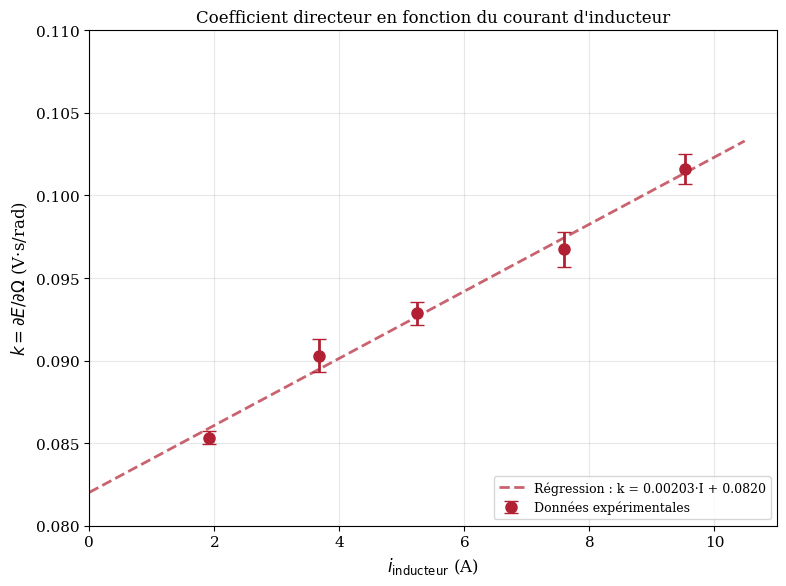


Régression k(i_inducteur) :
  α = 0.00203 ± 0.00012 (V·s/rad)/A
  β = 0.08202 ± 0.00074 V·s/rad


In [78]:
fig2, ax2 = plt.subplots(figsize=(8, 6))

I_inducteurs = np.array(list(results_regression.keys()), dtype=float)
slopes = np.array([results_regression[I]['slope'] for I in I_inducteurs], dtype=float)
slopes_u = np.array([results_regression[I]['slope_stderr'] for I in I_inducteurs], dtype=float)

ax2.errorbar(I_inducteurs, slopes, yerr=slopes_u,
             fmt='o', color=ROUGE, capsize=5, markersize=8, linewidth=2,
             label='Données expérimentales')

# Régression linéaire k = α I + β
alpha, u_alpha, beta, u_beta = linregress_with_uncertainties(I_inducteurs, slopes)
I_fit = np.linspace(0, max(I_inducteurs)*1.1, 100)
k_fit = alpha * I_fit + beta
ax2.plot(I_fit, k_fit, '--', color=ROUGE, alpha=0.7, linewidth=2,
         label=f"Régression : k = {alpha:.5f}·I + {beta:.4f}")

ax2.set_xlabel(r'$i_{\mathrm{inducteur}}$ (A)', fontsize=12)
ax2.set_ylabel(r'$k = \partial E / \partial \Omega$ (V·s/rad)', fontsize=12)
ax2.set_title("Coefficient directeur en fonction du courant d'inducteur", fontsize=12)
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 11)
ax2.set_ylim(0.08, 0.11)
plt.tight_layout()
plt.savefig('figures/figure2_k_I.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nRégression k(i_inducteur) :")
print(f"  α = {alpha:.5f} ± {u_alpha:.5f} (V·s/rad)/A")
print(f"  β = {beta:.5f} ± {u_beta:.5f} V·s/rad")

## 5. Données expérimentales - Rendement

In [79]:
R_pct = np.array([5, 10, 15, 25, 30, 35, 40, 50, 75, 100], dtype=float)  # %
P_abs = np.array([245.3, 302.3, 328, 335, 326, 318, 312, 303, 280, 266], dtype=float)  # W
P_induc = 16.0  # W
P_charge = np.array([80.4, 126, 141, 136, 125, 115, 107, 95, 69, 54], dtype=float)  # W

# Rendement
eta = P_charge / (P_abs + P_induc) * 100  # %

# Incertitudes
delta_P_abs = incertitude_puissance_pince(P_abs)                # W
delta_P_charge = incertitude_puissance_wattmetre(P_charge)      # W
delta_P_induc = float(incertitude_puissance_wattmetre(P_induc)) # W

P_tot = P_abs + P_induc
delta_P_tot = np.sqrt(delta_P_abs**2 + delta_P_induc**2)
delta_eta_rel = np.sqrt((delta_P_charge / P_charge)**2 + (delta_P_tot / P_tot)**2)
delta_eta = eta * delta_eta_rel

print("Données de rendement chargées (avec incertitudes).")

Données de rendement chargées (avec incertitudes).


## 6. Figure 3 : Rendement η(P_charge)

**Modèle polynomial empirique :** $\eta(P) = c_0 + c_1 P + c_2 P^2$.

**Méthode :** moindres carrés pondérés par $1/\Delta\eta$ (`numpy.polyfit`).  
Incertitudes sur coefficients estimées par bootstrap.

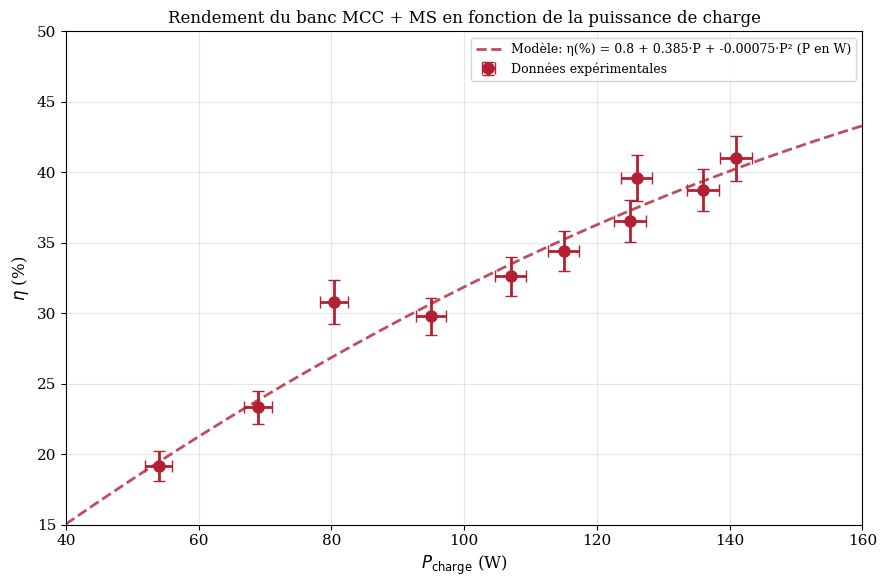

In [80]:
fig3, ax3 = plt.subplots(figsize=(9, 6))

ax3.errorbar(P_charge, eta, xerr=delta_P_charge, yerr=delta_eta,
             fmt='o', color=ROUGE, capsize=4, markersize=8, linewidth=2,
             label='Données expérimentales')

# Ajustement polynomial pondéré
weights = 1 / delta_eta
coeffs = np.polyfit(P_charge, eta, 2, w=weights)
c2, c1, c0 = coeffs

# Bootstrap pour incertitudes
n_boot = 1000
np.random.seed(42)
coeffs_boot = np.zeros((n_boot, 3))
for i in range(n_boot):
    eta_boot = eta + np.random.normal(0, delta_eta)
    coeffs_boot[i] = np.polyfit(P_charge, eta_boot, 2, w=weights)
coeffs_std = np.std(coeffs_boot, axis=0)

# Courbe ajustée
P_fit = np.linspace(40, 160, 200)
eta_fit = c0 + c1*P_fit + c2*P_fit**2

# Maximum
P_opt = -c1 / (2 * c2)
eta_max_theo = c0 + c1*P_opt + c2*P_opt**2

ax3.plot(P_fit, eta_fit, '--', color=ROUGE, alpha=0.8, linewidth=2,
         label=f"Modèle: η(%) = {c0:.1f} + {c1:.3f}·P + {c2:.5f}·P² (P en W)")

ax3.axvline(x=P_opt, color='gray', linestyle=':', alpha=0.7)
ax3.annotate(f"P_opt = {P_opt:.0f} W\nη_max(modèle) = {eta_max_theo:.1f} %",
             xy=(P_opt+5, 25), fontsize=10, color='gray')

ax3.set_xlabel(r'$P_{\mathrm{charge}}$ (W)', fontsize=12)
ax3.set_ylabel(r'$\eta$ (%)', fontsize=12)
ax3.set_title('Rendement du banc MCC + MS en fonction de la puissance de charge', fontsize=12)
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(40, 160)
ax3.set_ylim(15, 50)
plt.tight_layout()
plt.savefig('figures/figure3_rendement.png', dpi=300, bbox_inches='tight')
plt.show()

In [81]:
print("MODÈLE POLYNOMIAL : η(%) = c0 + c1·P + c2·P² (P en W)")
print("="*64)
print(f"c0 = {c0:.2f} ± {coeffs_std[2]:.2f} %")
print(f"c1 = {c1:.4f} ± {coeffs_std[1]:.4f} %/W")
print(f"c2 = {c2:.6f} ± {coeffs_std[0]:.6f} %/W²")
print(f"\nP_opt = -c1/(2c2) = {P_opt:.1f} W")
print(f"η_max (modèle) = {eta_max_theo:.1f} %")
i_max = int(np.argmax(eta))
print(f"η_max (exp.) = {eta[i_max]:.1f} ± {delta_eta[i_max]:.1f} % à P = {P_charge[i_max]:.0f} ± {delta_P_charge[i_max]:.0f} W")

MODÈLE POLYNOMIAL : η(%) = c0 + c1·P + c2·P² (P en W)
c0 = 0.82 ± 5.45 %
c1 = 0.3852 ± 0.1217 %/W
c2 = -0.000748 ± 0.000629 %/W²

P_opt = -c1/(2c2) = 257.4 W
η_max (modèle) = 50.4 %
η_max (exp.) = 41.0 ± 1.6 % à P = 141 ± 2 W


In [82]:
# Tableau complet (avec unités)
print("\nTableau des mesures de rendement :")
print("-"*94)
print(f"{'R (%)':<7} {'P_abs (W)':<12} {'ΔP_abs (W)':<12} {'P_ch (W)':<11} {'ΔP_ch (W)':<11} {'η (%)':<8} {'Δη (%)':<8}")
print("-"*94)
for i in range(len(R_pct)):
    print(f"{R_pct[i]:<7.0f} {P_abs[i]:<12.1f} {delta_P_abs[i]:<12.1f} "
          f"{P_charge[i]:<11.1f} {delta_P_charge[i]:<11.1f} {eta[i]:<8.1f} {delta_eta[i]:<8.1f}")


Tableau des mesures de rendement :
----------------------------------------------------------------------------------------------
R (%)   P_abs (W)    ΔP_abs (W)   P_ch (W)    ΔP_ch (W)   η (%)    Δη (%)  
----------------------------------------------------------------------------------------------
5       245.3        11.1         80.4        2.2         30.8     1.6     
10      302.3        11.7         126.0       2.4         39.6     1.7     
15      328.0        12.0         141.0       2.4         41.0     1.6     
25      335.0        12.0         136.0       2.4         38.7     1.5     
30      326.0        11.9         125.0       2.4         36.5     1.5     
35      318.0        11.9         115.0       2.3         34.4     1.4     
40      312.0        11.8         107.0       2.3         32.6     1.4     
50      303.0        11.7         95.0        2.2         29.8     1.3     
75      280.0        11.5         69.0        2.1         23.3     1.2     
100     266.0 

## 7. Figure 4 : Magnétisme rémanent (Bonus)

Mesures avec $i_{inducteur} = 0$. Seulement 3 points → analyse qualitative.


Tableau des mesures (i_inducteur = 0) :
------------------------------------------------------------------
Ω (rad/s)    u(Ω) (rad/s)    E (V)    u(E) (V)  
------------------------------------------------------------------
83.78        1.24            56.00    0.59      
104.72       1.52            61.00    0.64      
127.41       1.84            65.00    0.68      


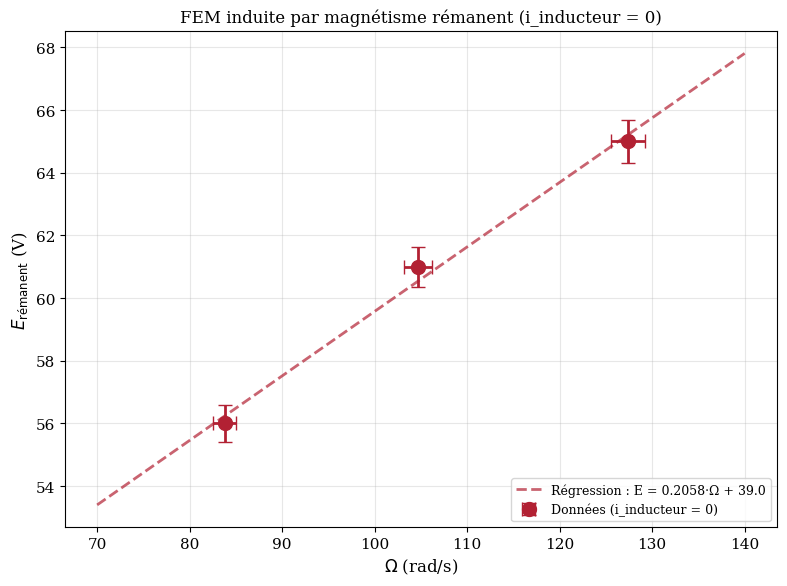


Régression rémanence :
  a = 0.2058 ± 0.0180 V·s/rad
  b = 39.0 ± 1.9 V
  Domaine : Ω ∈ [83.8, 127.4] rad/s (3 points)
  ⚠️ L'ordonnée à l'origine est une extrapolation peu fiable.


In [83]:
U_tachy_rem = np.array([48, 60, 73], dtype=float)
E_rem = np.array([56, 61, 65], dtype=float)

omega_rem = convert_to_omega_rad(U_tachy_rem)
delta_omega_rem = incertitude_omega(U_tachy_rem)
delta_E_rem = incertitude_tension(E_rem)

print("\nTableau des mesures (i_inducteur = 0) :")
print('-'*66)
print(f"{'Ω (rad/s)':<12} {'u(Ω) (rad/s)':<15} {'E (V)':<8} {'u(E) (V)':<10}")
print('-'*66)
for om, uom, e, ue in zip(omega_rem, delta_omega_rem, E_rem, delta_E_rem):
    print(f"{om:<12.2f} {uom:<15.2f} {e:<8.2f} {ue:<10.2f}")


fig4, ax4 = plt.subplots(figsize=(8, 6))

ax4.errorbar(omega_rem, E_rem, xerr=delta_omega_rem, yerr=delta_E_rem,
             fmt='o', color=ROUGE, capsize=5, markersize=10, linewidth=2,
             label='Données (i_inducteur = 0)')

a_rem, ua_rem, b_rem, ub_rem = linregress_with_uncertainties(omega_rem, E_rem)
omega_fit_rem = np.linspace(70, 140, 100)
E_fit_rem = a_rem * omega_fit_rem + b_rem
ax4.plot(omega_fit_rem, E_fit_rem, '--', color=ROUGE, alpha=0.7, linewidth=2,
         label=f"Régression : E = {a_rem:.4f}·Ω + {b_rem:.1f}")

ax4.set_xlabel(r'$\Omega$ (rad/s)', fontsize=12)
ax4.set_ylabel(r'$E_{\mathrm{rémanent}}$ (V)', fontsize=12)
ax4.set_title("FEM induite par magnétisme rémanent (i_inducteur = 0)", fontsize=12)
ax4.legend(loc='lower right', fontsize=9)
ax4.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/figure4_remanence.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nRégression rémanence :")
print(f"  a = {a_rem:.4f} ± {ua_rem:.4f} V·s/rad")
print(f"  b = {b_rem:.1f} ± {ub_rem:.1f} V")
print(f"  Domaine : Ω ∈ [{min(omega_rem):.1f}, {max(omega_rem):.1f}] rad/s (3 points)")
print(f"  ⚠️ L'ordonnée à l'origine est une extrapolation peu fiable.")

## 8. Résumé des résultats

In [84]:
print("="*72)
print("RÉSUMÉ DES RÉSULTATS (avec unités)")
print("="*72)

print("\n1) Régressions E(Ω) :")
for I_ind, res in results_regression.items():
    print(f"   i = {I_ind:.2f} A : a = {res['slope']:.4f} ± {res['slope_stderr']:.4f} V·s/rad ; "
          f"b = {res['intercept']:.2f} ± {res['intercept_stderr']:.2f} V")

print("\n2) Relation k(i_inducteur) :")
print(f"   α = {alpha:.5f} ± {u_alpha:.5f} (V·s/rad)/A")
print(f"   β = {beta:.5f} ± {u_beta:.5f} V·s/rad")

i_max = int(np.argmax(eta))
print("\n3) Rendement maximum (expérimental) :")
print(f"   η_max = {eta[i_max]:.1f} ± {delta_eta[i_max]:.1f} %")
print(f"   à P_charge = {P_charge[i_max]:.0f} ± {delta_P_charge[i_max]:.0f} W")

print("\n4) Rémanence (i_inducteur = 0) :")
print(f"   a = {a_rem:.4f} ± {ua_rem:.4f} V·s/rad")
print(f"   b = {b_rem:.1f} ± {ub_rem:.1f} V")
print("="*72)

RÉSUMÉ DES RÉSULTATS (avec unités)

1) Régressions E(Ω) :
   i = 1.91 A : a = 0.0853 ± 0.0004 V·s/rad ; b = 0.25 ± 0.03 V
   i = 3.68 A : a = 0.0903 ± 0.0010 V·s/rad ; b = 0.13 ± 0.08 V
   i = 5.24 A : a = 0.0929 ± 0.0007 V·s/rad ; b = 0.24 ± 0.06 V
   i = 7.60 A : a = 0.0967 ± 0.0011 V·s/rad ; b = 0.36 ± 0.10 V
   i = 9.53 A : a = 0.1016 ± 0.0009 V·s/rad ; b = 0.37 ± 0.09 V

2) Relation k(i_inducteur) :
   α = 0.00203 ± 0.00012 (V·s/rad)/A
   β = 0.08202 ± 0.00074 V·s/rad

3) Rendement maximum (expérimental) :
   η_max = 41.0 ± 1.6 %
   à P_charge = 141 ± 2 W

4) Rémanence (i_inducteur = 0) :
   a = 0.2058 ± 0.0180 V·s/rad
   b = 39.0 ± 1.9 V
